In [1]:
# the rest of the imports require the location to be the base of the repo 
#   i.e., SARS-CoV-2-network-analysis)
# run this first if needed to get to the right directory
import os
os.chdir('../../')
# os.chdir('/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis')
os.getcwd()

'/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis'

In [2]:
from collections import defaultdict
import argparse
import os, sys
from tqdm import tqdm
import itertools
#import utils.file_utils as utils
# also compute the significance of sinksource vs local
#from scipy.stats import kruskal, mannwhitneyu
# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))
# make this the default for now
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1.2)
# my local imports
# fss_dir = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
# sys.path.insert(0,fss_dir)
from src.FastSinkSource.src.plot import plot_utils
from src.FastSinkSource.src.algorithms import runner
from src.FastSinkSource.src.evaluate import cross_validation as cv


%matplotlib inline  

python version: 3.7.7 (default, Mar 13 2020, 13:32:22) 
matplotlib version: 3.2.1
seaborn version: 0.10.0
pandas version: 1.0.3
numpy version: 1.18.2


In [3]:
def set_title(**kwargs):
    title = kwargs.get('title', '')
    title += " %s%s%s" % (
        " neg-factor=%s;"%kwargs['sample_neg_examples_factor'] if kwargs.get('sample_neg_examples_factor') else '',
        " seed=%s;"%kwargs['cv_seed'] if kwargs.get('cv_seed') else "",
        " # reps=%s;"%kwargs['num_reps'] if kwargs.get('num_reps',1) > 1 else "",
    )
    return title

In [61]:
# string 700
# config_file = "fss_inputs/config_files/params-testing/700-cv5-nf5-nr100-ace2.yaml"
# postfix = ""
# out_file = "outputs/viz/params-testing/string700-ace2-cv5-nf1-5-10-eprec.pdf"
# config_file = "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2-and-deepnf.yaml"
config_file = "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml"
# if the pipeline was ran with --postfix set, then specify that value here:
postfix = "-eprec"
out_file = "outputs/viz/params-testing/string-ace2-cv5-nf1-5-10-eprec.pdf"
os.makedirs(os.path.dirname(out_file), exist_ok=True)
df_all2 = pd.DataFrame()
for neg_factor in [1,5,10]:
#     algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression', 'deepnf']
    algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression']
#     algs = ['genemaniaplus']
    # to get early precision at 0.3 recall, need to specify --early-prec 0.3 when running the pipeline
    measures = ['auroc', 'auprc', 'eprec-rec0.3']
#     measures = ['auroc', 'auprc', 'eprec-rec0.1', 'eprec-rec0.2', 'eprec-rec0.3']
    compare_params = {
        'genemaniaplus': "alpha",
        'genemania': "alpha",
        'sinksourceplus': "lambda",
        'sinksource': None,
        'logistic_regression': 'C',
        'svm': 'C',
        'deepnf': 'C',
    }
    compare_params2 = {plot_utils.ALG_NAMES[alg]: val for alg, val in compare_params.items()}
    df_all = pd.DataFrame()
    print(config_file)
    config_map = plot_utils.load_config_file(config_file)
    for alg in algs:
        kwargs = {'algs': [alg], 'compare_param':compare_params[alg], 'measures': measures, 'sample_neg_examples_factor': neg_factor}
        kwargs['postfix'] = postfix
        input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
                config_map, '', **kwargs)
#         print(kwargs)

        df = plot_utils.load_all_results(input_settings, alg_settings, output_settings, **kwargs)
        df.rename(columns={'Algorithm': 'param_val'}, inplace=True)
        df_all = pd.concat([df_all, df])

    df_all.head()
    # plot_utils.results_overview(df_all, measures=kwargs['measures'])
    # rename the measures
    df_all['plot_exp_name'] = df_all['plot_exp_name'].replace("STRING-400", 'STRING')
    df_all.drop(columns=['avgp', 'eprec-reck1'], inplace=True)

    df2 = df_all.melt(id_vars=['alg_name', 'param_val', 'plot_exp_name'], value_vars=measures, var_name='measure')
    df2['measure'] = df2['measure'].replace("fmax", 'Fmax')
    df2['measure'] = df2['measure'].apply(lambda x: x.replace('eprec-rec', 'EPR @'))
#     df2['measure'] = df2['measure'].replace("fmax", 'Fmax').replace('eprec-rec0.1', 'EPR @0.1')

    # now combine the name and measure column
    df2['exp_name'] = df2['plot_exp_name'] + ' ' + df2['measure']
    # df2.sort_values('exp_name', inplace=True)
    df2.head()
    df2['alg_name'] += " P:N 1:%s" % neg_factor
    df_all2 = pd.concat([df_all2, df2])


fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml
fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml
fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml


In [62]:
df2 = df_all2
df_all2.head()

,alg_name,param_val,plot_exp_name,measure,value,exp_name
0,RL P:N 1:1,0.01,STRING,auroc,0.7724,STRING auroc
1,RL P:N 1:1,0.01,STRING,auroc,0.7855,STRING auroc
2,RL P:N 1:1,0.01,STRING,auroc,0.7588,STRING auroc
3,RL P:N 1:1,0.01,STRING,auroc,0.7507,STRING auroc
4,RL P:N 1:1,0.01,STRING,auroc,0.7417,STRING auroc


/data/jeff-law/tools/anaconda3/envs/covid19/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


outputs/viz/params-testing/string-ace2-cv5-nf1-5-10-eprec.pdf


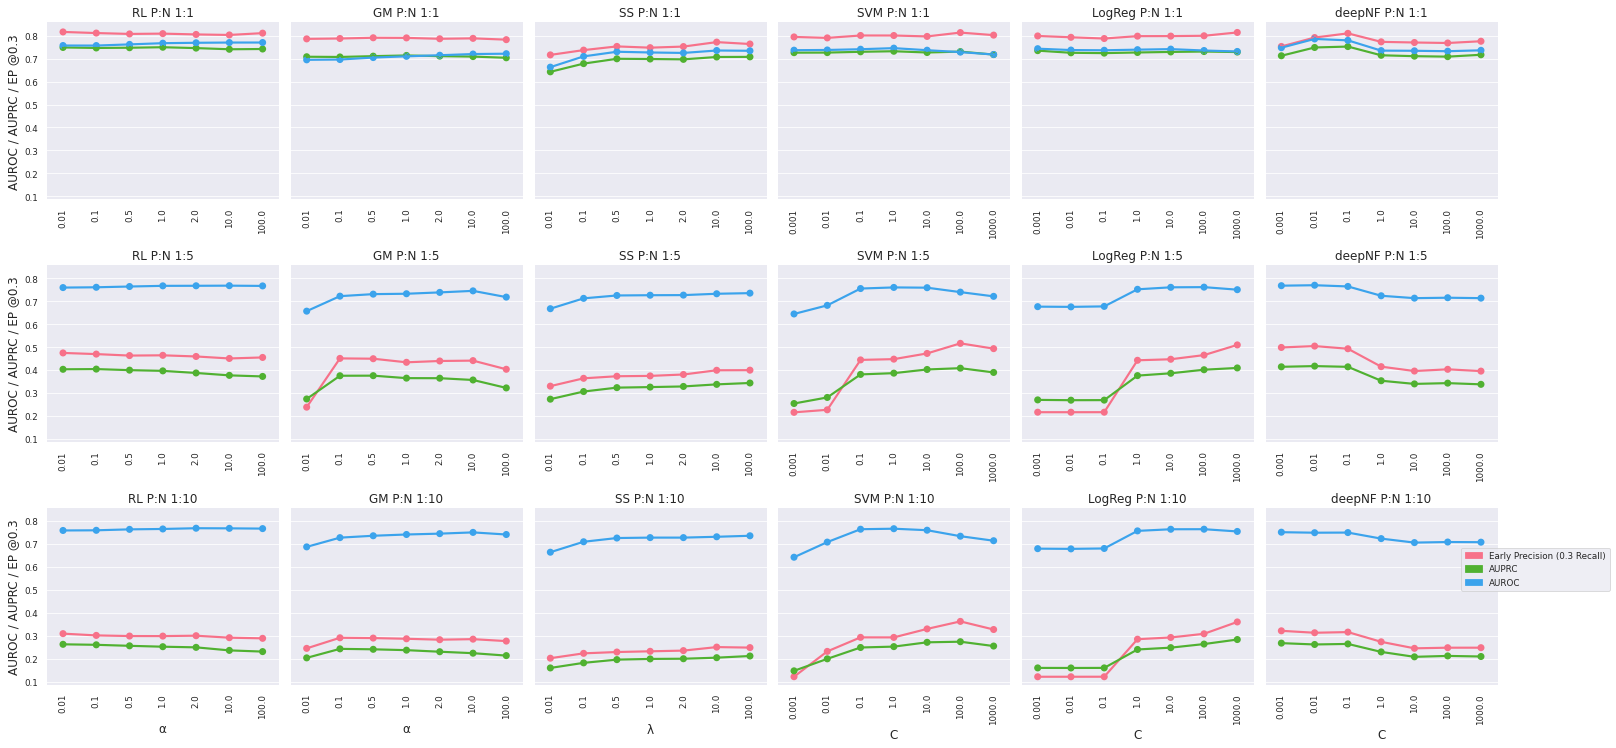

In [58]:
exp_names = sorted(df2['exp_name'].unique())
hue_order = [n for n in exp_names if 'STRING' in n] + [n for n in exp_names if 'HPA-P-Lung' in n] + [n for n in exp_names if 'HPA-R-Lung' in n]
df2['param_val'] = df2['param_val'].astype(float)
    
g = sns.FacetGrid(
    df2, height=3.5, aspect=1,
    col="alg_name",
#     col_order=algs,
    hue='exp_name', hue_order=hue_order,
    col_wrap=6,
    palette=sns.color_palette("husl", 3),
    sharex=False)
# Create the line plot on each subplot
g.map(
    sns.pointplot,
    'param_val', 'value', saturation=0.8, # order=df2['param_val'].unique(),
    ).set_titles('{col_name}')
# g.add_legend()
# g.set(x_tick)
for i, ax in enumerate(g.axes.flat):
#     make sure the order is correct
#     title = ax.get_title()
#     ax.
    ax.tick_params(axis='x', rotation=90)
    alg = ax.get_title()
    ax.set_title(alg, fontsize=12)
    if "1:10" in alg:
        alg = alg.replace(" P:N 1:10","")
        p = compare_params2[alg]
        ax.set_xlabel(plot_utils.param_map.get(p,p), fontsize=12)
#     ax.set_ylim(0.125, 0.925)
    if ax.get_ylabel() != "":
#         ax.set_ylabel(r"F$_{\mathrm{max}}$ / EP @0.1", fontsize=12)
        ax.set_ylabel(r"AUROC / AUPRC / EP @0.3", fontsize=12)
#     if i == len(g.axes.flat)-1:
#         ax.legend()
# for some reason the legend isn't being created. Found a workaround here:
# https://github.com/mwaskom/seaborn/issues/1166
# labels = hue_order
labels = ["Early Precision (0.3 Recall)", "AUPRC", "AUROC"]
colors = sns.color_palette("husl", 3)
handles = [matplotlib.patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]

plt.tight_layout()
plt.legend(handles=handles, bbox_to_anchor=(1.5,0.8))
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')

/data/jeff-law/tools/anaconda3/envs/covid19/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


outputs/viz/params-testing/string-ace2-cv5-nf1-5-10-eprec.pdf


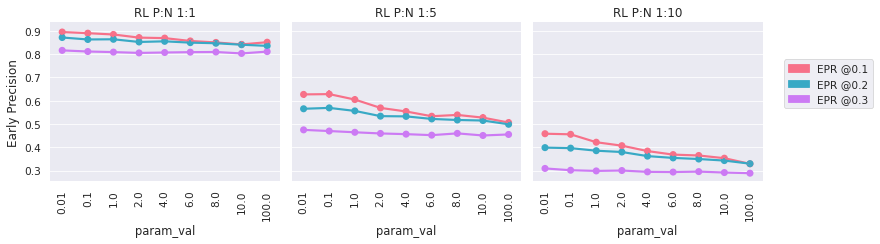

In [46]:
# this is code leftover for comparing the precision at different recall values 
exp_names = sorted(df2['exp_name'].unique())
hue_order = [n for n in exp_names if 'STRING' in n] + [n for n in exp_names if 'HPA-P-Lung' in n] + [n for n in exp_names if 'HPA-R-Lung' in n]
df2['param_val'] = df2['param_val'].astype(float)
colors = sns.color_palette("husl", len(epr_values)+2)
colors = [colors[0]] + colors[3:]
# colors = sns.color_palette("husl", len(epr_values))
    
g = sns.FacetGrid(
    df2, height=3.5, aspect=1,
    col="alg_name",
#     col_order=algs,
    hue='exp_name', hue_order=hue_order,
    col_wrap=5,
    palette=colors,
    sharex=False)
# Create the line plot on each subplot
g.map(
    sns.pointplot,
    'param_val', 'value', saturation=0.8, # order=df2['param_val'].unique(),
    ).set_titles('{col_name}')
# g.add_legend()
# g.set(x_tick)
for i, ax in enumerate(g.axes.flat):
#     make sure the order is correct
#     title = ax.get_title()
#     ax.
    ax.tick_params(axis='x', rotation=90)
    alg = ax.get_title()
    ax.set_title(alg, fontsize=12)
#     p = compare_params2[alg]
#     ax.set_xlabel(plot_utils.param_map.get(p,p), fontsize=12)
#     ax.set_ylim(0.125, 0.925)
    if ax.get_ylabel() != "":
        ax.set_ylabel(r"Early Precision", fontsize=12)
#     if i == len(g.axes.flat)-1:
#         ax.legend()
# for some reason the legend isn't being created. Found a workaround here:
# https://github.com/mwaskom/seaborn/issues/1166
# labels = hue_order
labels = ['EPR @%s' % epr for epr in epr_values]
handles = [matplotlib.patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]

plt.tight_layout()
plt.legend(handles=handles, bbox_to_anchor=(1.5,0.8))
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')

## Backup
Below are old approaches I tried

     Algorithm plot_exp_name  neg_factor                      measure   value  \
1986       GM+        STRING           1  Early Precision @0.1 Recall  1.6098   
1987       GM+        STRING           1  Early Precision @0.1 Recall  1.8858   
1988       GM+        STRING           1  Early Precision @0.1 Recall  1.6500   
1989       GM+        STRING           1  Early Precision @0.1 Recall  1.6924   
1990       GM+        STRING           1  Early Precision @0.1 Recall  1.9412   

                                 exp_name  
1986  Early Precision @0.1 Recall P:N 1:1  
1987  Early Precision @0.1 Recall P:N 1:1  
1988  Early Precision @0.1 Recall P:N 1:1  
1989  Early Precision @0.1 Recall P:N 1:1  
1990  Early Precision @0.1 Recall P:N 1:1  
  Algorithm plot_exp_name  neg_factor             measure   value  \
0       GM+        STRING           1  F$_{\mathrm{max}}$  1.4560   
1       GM+        STRING           1  F$_{\mathrm{max}}$  1.4588   
2       GM+        STRING           1  F$_

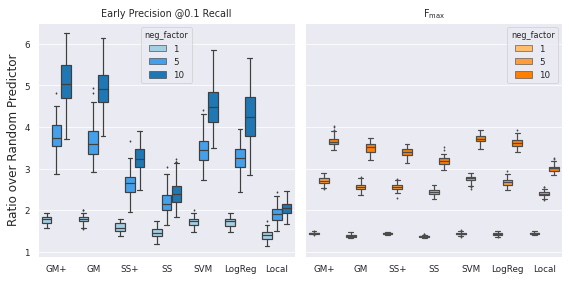

In [46]:
f, axes = plt.subplots(ncols=2, sharey=True, figsize=(8,4))
for i, (ax, (measure, curr_df)) in enumerate(zip(axes, df2.groupby('measure'))):
#     curr_df = df2[df2['measure'] == measure]
    print(curr_df.head())
#     print(triple_colors[i*3:(i+1)*3])
    ax = sns.boxplot(x='Algorithm', y='value', data=curr_df, saturation=1,
                hue='neg_factor', fliersize=1, palette=triple_colors[i*3:(i+1)*3], ax=ax)
#     ax = sns.pointplot(x='Algorithm', y='value', data=curr_df,
#                 hue='neg_factor', fliersize=1, palette=triple_colors[i*3:(i+1)*3], ax=ax)
    
    ax.set_title(measure)
    if i == 0:
        ax.set_ylabel("Ratio over Random Predictor", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
print(out_file)
# plt.savefig(out_file)
# plt.savefig(out_file.replace('.pdf','.svg'))

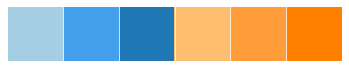

In [27]:
triple_colors = my_palette = ["#a6cee3", "#45a0eb", "#1f78b4",
              "#fdbf6f", "#ff9d3b", "#ff7f00",
             ]
# sns.color_palette("Paired", )
sns.palplot(triple_colors)

outputs/viz/stringv11/400/2020-03-sarscov2-human-ppi-ace2/fmax-epr-box.pdf


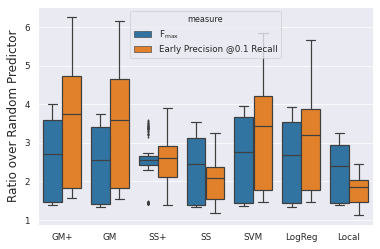

In [24]:
ax = sns.boxplot(x='Algorithm', y='value', data=df2,
            hue='measure', fliersize=1)
ax.set_ylabel("Ratio over Random Predictor", fontsize=12)
ax.set_xlabel("")

print(out_file)
plt.savefig(out_file)
plt.savefig(out_file.replace('.pdf','.svg'))

outputs/viz/stringv11/400/2020-03-sarscov2-human-ppi-ace2/fmax-epr-box.pdf


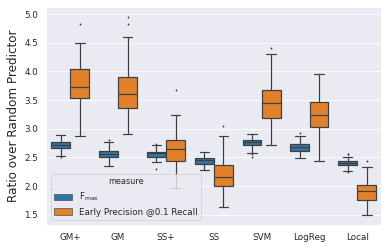

In [8]:
ax = sns.boxplot(x='Algorithm', y='value', data=df2,
            hue='measure', fliersize=1)
ax.set_ylabel("Ratio over Random Predictor", fontsize=12)
ax.set_xlabel("")

print(out_file)
plt.savefig(out_file)
plt.savefig(out_file.replace('.pdf','.svg'))

/data/jeff-law/tools/anaconda3/envs/covid19/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


AttributeError: 'FacetGrid' object has no attribute 'set_ylabel'

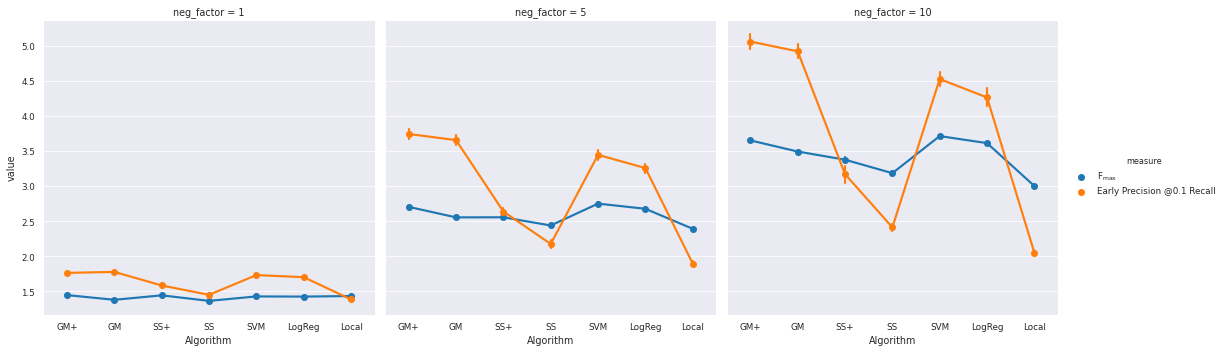

In [17]:
ax = sns.factorplot(x='Algorithm', y='value', data=df2, 
                    col='neg_factor', hue='measure', fliersize=1)
ax.set_ylabel("Ratio over Random Predictor", fontsize=12)
ax.set_xlabel("")

print(out_file)
# plt.savefig(out_file)
# plt.savefig(out_file.replace('.pdf','.svg'))

/data/jeff-law/tools/anaconda3/envs/covid19/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


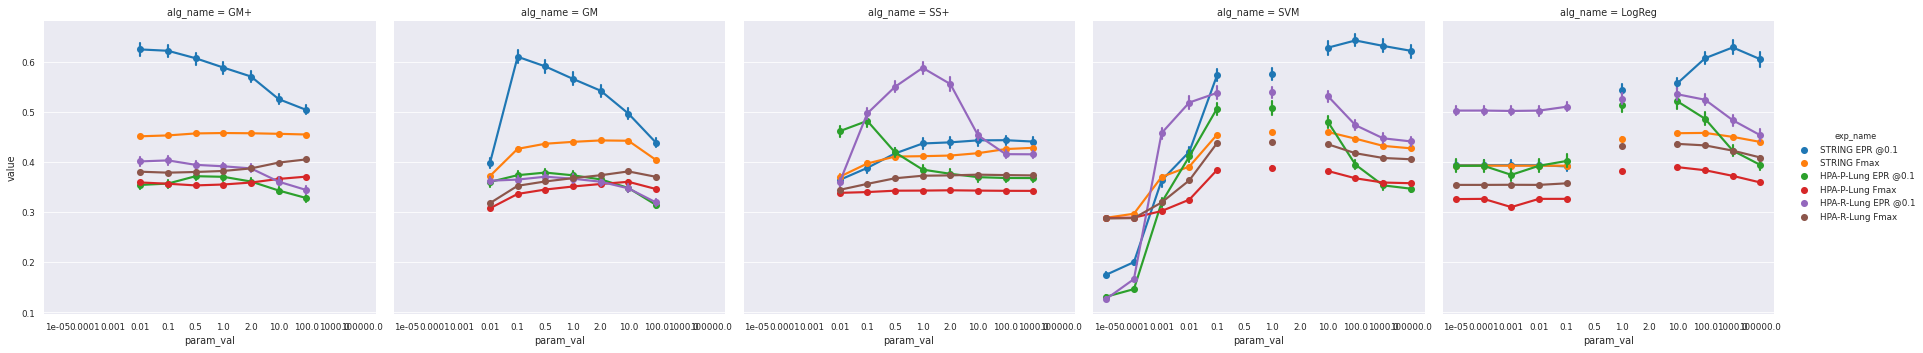

In [79]:
sns.factorplot(x='param_val', y='value', data=df2, col='alg_name', hue='exp_name', hue_order=hue_order)

In [25]:
# also update the font size of the x and y ticks
# matplotlib.rc('xtick', labelsize=16) 
# matplotlib.rc('ytick', labelsize=16)
my_palette = plot_utils.my_palette

# now make a point plot
def pointplot(
    df2, ax=None, out_file=None, title="", order=None,
    x='param_val', y='value', hue='plot_exp_name', ymin=None, ymax=None):
    if ax is None:
#         f, ax = plt.subplots(figsize=(20,6))
        f, ax = plt.subplots()
    exp_names = sorted(df2['exp_name'].unique())
    hue_order = [n for n in exp_names if 'STRING' in n] + [n for n in exp_names if 'HPA-P-Lung' in n] + [n for n in exp_names if 'HPA-R-Lung' in n]
    ax = sns.pointplot(
        x=x, y=y, data=df2, 
        hue='exp_name', hue_order=hue_order, order=order,
        dodge=True, ax=ax, palette='Paired',
    )

    if ymin is not None and ymax is not None:
        ax.set_ylim(ymin, ymax)
    ax.set_ylabel(y, weight='bold', fontsize=16)
    ax.set_xlabel('')
    ax.set_title(title, weight='bold', fontsize=18)
    
    plt.setp(ax.lines,linewidth=1)  # set lw for all lines of g axes
#     ax.tick_params(axis='x', rotation=90)  # rotate the x-axis labels
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    if out_file is not None:
        print(out_file)
        plt.savefig(out_file, bbox_inches='tight')
        plt.show()
        plt.close()